In [12]:
#Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [2]:
#Load data
train = pd.read_csv('./data/train_data.csv', index_col=0).reset_index(drop=True)
test = pd.read_csv('./data/test_data.csv', index_col=0).reset_index(drop=True)

scaled_train = pd.read_csv('./data/scaled_train.csv', index_col=0).reset_index(drop=True)
scaled_test = pd.read_csv('./data/scaled_test.csv', index_col=0).reset_index(drop=True)

In [3]:
X_train = train.drop(columns=['quality'])
X_test = test.drop(columns=['quality'])
y_train = train['quality']
y_test = test['quality']

X_scaled_train = scaled_train.drop(columns=['quality'])
X_scaled_test = scaled_test.drop(columns=['quality'])
y_scaled_train = scaled_train['quality']
y_scaled_test = scaled_test['quality']

## Evaluation Functions

In [7]:
def plot_roc(fpr1, tpr1, fpr0, tpr0):
    """Plot the ROC curve."""
    
    plt.plot(fpr1, tpr1, color='darkorange', lw=2, label='ROC curve for 1')
    plt.plot(fpr0, tpr0, color='navy', lw=2, label='ROC curve for 0')
    plt.plot([0,1], [0,1], lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    
    plt.legend()
    plt.show()

In [8]:
def evaluate(model, X_train, X_test, y_train, y_test):
    """Obtain the metrics for evaluation of the model."""
    
    #Fit and predict the model
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    #Calculate metrics
    train_RMSE = mean_squared_error(y_train, train_pred, squared=False)
    train_R2 = r2_score(y_train, train_pred)
    test_RMSE = mean_squared_error(y_test, y_pred, squared=False)
    test_R2 = r2_score(y_test, y_pred)
    
    #Print model name
    print(model)
    
    #Print reports
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    
    print("\nTrain RMSE: {}\nTest RMSE: {}\nTrain R2 score: {}\nTest R2 score: {}".format(
        train_RMSE, test_RMSE, train_R2, test_R2))
    
    #Get probability estimates for roc curve
    probs = model.predict_proba(X_test)
    y_score1 = probs[:,1]
    y_score0 = probs[:,0]
    
    #Calculate ROC metrics
    fpr1, tpr1, thresholds1 = roc_curve(y_test, y_score1)
    fpr0, tpr0, thresholds0 = roc_curve(y_test, y_score0)
    
    #Print AUC
    print("AUC for classifying as good (1): {}\nAUC for classifying as bad (0): {}.".format(
        auc(fpr1, tpr1), auc(fpr0, tpr0)))
    
    plot_roc(fpr1, tpr1, fpr0, tpr0)

## Gradient Boosting <a name='gboost'></a>
Trying out gradient boosting algorithm for my classification model, with both the scaled and unscaled data. I expect there to be very little, if any, difference between the scaled and unscaled data.

I will be hyperparameter tuning both via `RandomizedSearchCV` and `GridSearchCV`.

In [6]:
#Create gradient boosting
gb = GradientBoostingClassifier()

#Create model parameters to test
params = {'learning_rate': [0.001, 0.01, 0.1, 0.3, 0.5, 0.75, 1],
          'max_depth': [3, 5, 10, 25, 50, 100],
          'n_estimators':[10, 20, 100, 200, 300, 500],
          'max_features':[2, 5, 10, 'auto', 'sqrt'],
          'random_state':[42]
         }

#Create gridsearchcv
gb_rcv = RandomizedSearchCV(gb, param_distributions=params, cv=5, scoring='roc_auc')

#Fit model on unscaled training set
gb_rcv.fit(X_train, y_train)

#print best parameters and score
print(gb_rcv.best_params_, gb_rcv.best_score_)

{'random_state': 42, 'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 25, 'learning_rate': 0.001} 0.7015801332534186


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.001, loss='deviance', max_depth=25,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
              precision    recall  f1-score   support

         0.0       0.64      0.67      0.66      5766
         1.0       0.65      0.62      0.64      5759

    accuracy                           0.65     11525
   macro avg       0.65      0.65      0.65     11525
weighted avg       0.65     

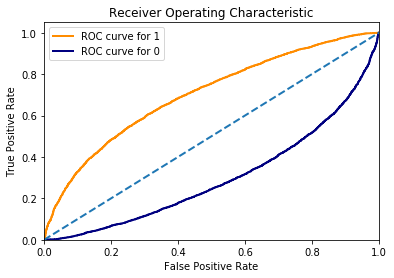

In [15]:
#Create gradient boosting with the best hyperparameters found
gb_rbest = GradientBoostingClassifier(n_estimators=500, max_features='sqrt', max_depth=25, learning_rate=0.001, random_state=42)

#Evaluate model on unscaled data
evaluate(gb_rbest, X_train, X_test, y_train, y_test)

To see if scaling the data makes any difference:

In [14]:
#Create gradient boosting
gb = GradientBoostingClassifier()

#Create model parameters to test
params = {'learning_rate': [0.001, 0.01, 0.1, 0.3, 0.5, 0.75, 1],
          'max_depth': [3, 5, 10, 25, 50, 100],
          'n_estimators':[10, 20, 100, 200, 300, 500],
          'max_features':[2, 5, 10, 'auto', 'sqrt'],
          'random_state':[42]
         }

#Create gridsearchcv
scaledgb_rcv = RandomizedSearchCV(gb, param_distributions=params, cv=5, scoring='roc_auc')

#Fit model on unscaled training set
scaledgb_rcv.fit(X_scaled_train, y_scaled_train)

#print best parameters and score
print(scaledgb_rcv.best_params_, scaledgb_rcv.best_score_)

{'random_state': 42, 'n_estimators': 500, 'max_features': 5, 'max_depth': 5, 'learning_rate': 0.1} 0.6998288801247237


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=5, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
              precision    recall  f1-score   support

         0.0       0.64      0.67      0.66      5766
         1.0       0.65      0.62      0.64      5759

    accuracy                           0.65     11525
   macro avg       0.65      0.65      0.65     11525
weighted avg       0.65      0.65   

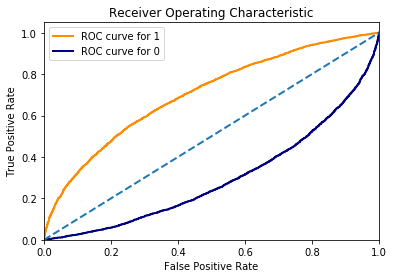

In [16]:
#Create gradient boosting with the best hyperparameters found
scaledgb_rbest = GradientBoostingClassifier(n_estimators=500, max_features=5, max_depth=5, learning_rate=0.1, random_state=42)

#Evaluate model on unscaled data
evaluate(scaledgb_rbest, X_scaled_train, X_scaled_test, y_scaled_train, y_scaled_test)

Using `GridSearchCV`:

In [ ]:
#Create gradient boosting
gb = GradientBoostingClassifier()

#Create model parameters to test
params = {'learning_rate': [0.001, 0.01, 0.1, 0.3, 0.5, 0.75, 1],
          'max_depth': [3, 5, 10, 25, 50, 100],
          'n_estimators':[10, 20, 100, 200, 300, 500],
          'max_features':[2, 5, 10, 'auto', 'sqrt'],
          'random_state':[42]
         }

#Create gridsearchcv
gb_cv = GridSearchCV(gb, param_grid=params, cv=5, scoring='roc_auc')

#Fit model on training set
gb_cv.fit(X_train, y_train)

#print best parameters and score
print(gb_cv.best_params_, gb_cv.best_score_)